In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa

import os
import numpy as np

# plotting
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import IPython.display as display

# to display confusion matrix
import seaborn as sn
import pandas as pd

In [2]:
#paths para os datasets
pathTrain = 'GTSRB_TP/train_images'
pathTest = 'GTSRB_TP/test_images'


In [9]:
BATCH_SIZE = 32
HEIGHT = 128
WIDTH = 128

### Aux function to show a batch


In [4]:
def show_batch(image_batch, label_batch, epoch):
  columns = 5
  rows = BATCH_SIZE / columns + 1  
  epochImages = plt.figure(figsize=(15, 3 * rows))
  epochImages.suptitle('epoch {}'.format(epoch))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(int(rows), columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')


### Auxiliary functions to load image


In [5]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [WIDTH, HEIGHT])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

### Function to process images

In [6]:
def process_image(image, label):
    
    #image = tf.image.resize(image, (64,64))
    
    r = tf.random.uniform(shape=(), minval=0, maxval=0.5) - 0.25
    image = tfa.image.rotate(image, r)
    
    rx = tf.random.uniform(shape=(), minval=0, maxval=20) - 10
    ry = tf.random.uniform(shape=(), minval=0, maxval=8) - 4
    image = tfa.image.translate(image, [rx, ry])
    #image = tfa.image.random_hsv_in_yiq(image, 0.5, 0.9, 1.1, 0.9, 1.3)
    #image = tf.image.resize(image, (32,32))
    image = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 
                    0.4,
                    0.4,1.4,
                    0.4, 1.4), 0.0, 1.0)
    return image, label

### Prepare dataset

In [7]:
data_dir = pathlib.Path(pathTrain)
classNames = np.array(os.listdir(data_dir))
print(classNames)


['00000' '00001' '00002' '00003' '00004' '00005' '00006' '00007' '00008'
 '00009' '00010' '00011' '00012' '00013' '00014' '00015' '00016' '00017'
 '00018' '00019' '00020' '00021' '00022' '00023' '00024' '00025' '00026'
 '00027' '00028' '00029' '00030' '00031' '00032' '00033' '00034' '00035'
 '00036' '00037' '00038' '00039' '00040' '00041' '00042']


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

listset = tf.data.Dataset.list_files(pathTrain+"/*/*.png")
dataset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)


In [11]:
dataset = dataset.prefetch(buffer_size=AUTOTUNE)
dataset = dataset.map(process_image)
# shuffle elements, to shuffle batches place shuffle after batch
dataset = dataset.shuffle(32)
dataset = dataset.batch(batch_size = BATCH_SIZE)
#dataset = dataset.repeat()

## Show images for three epochs


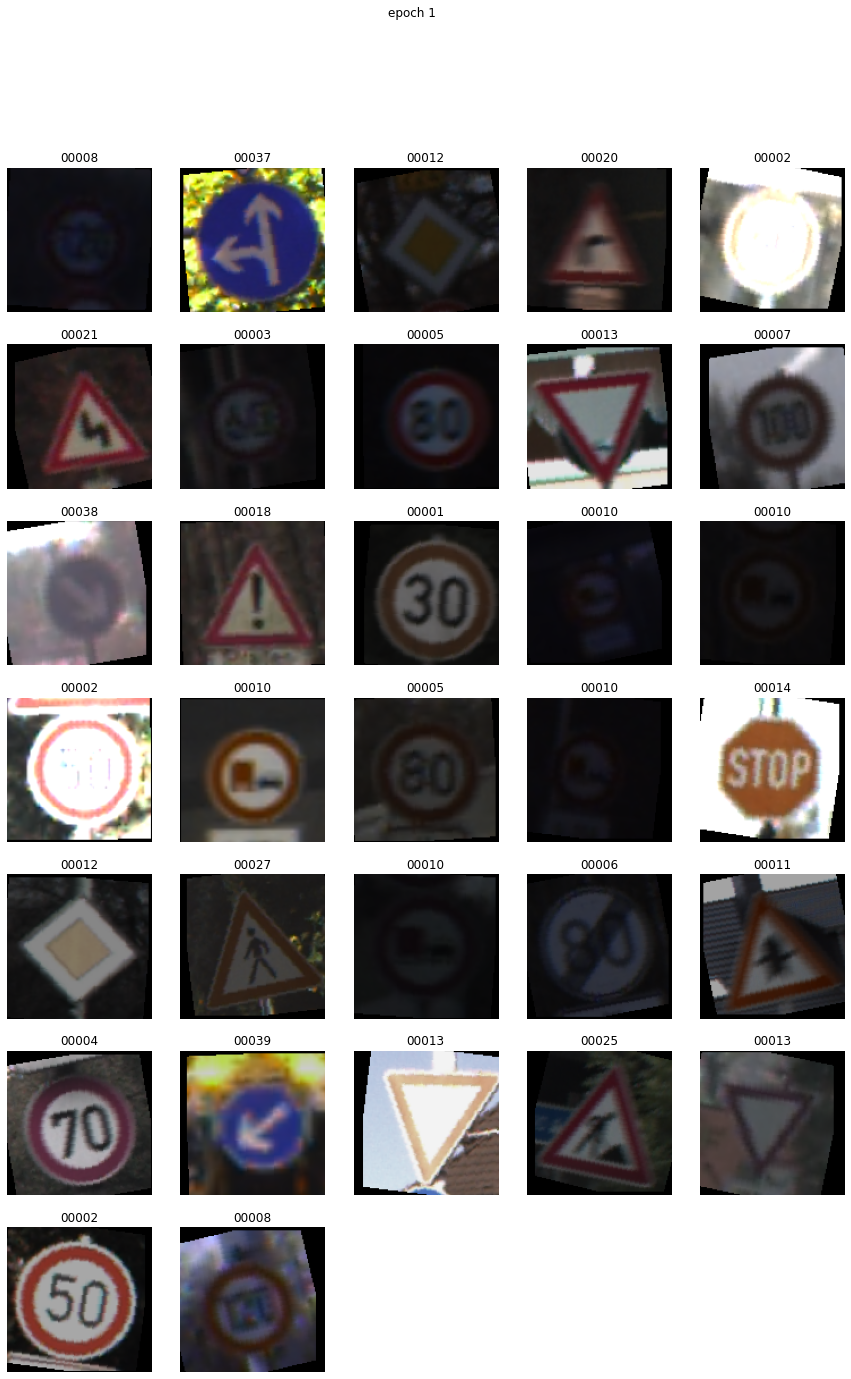

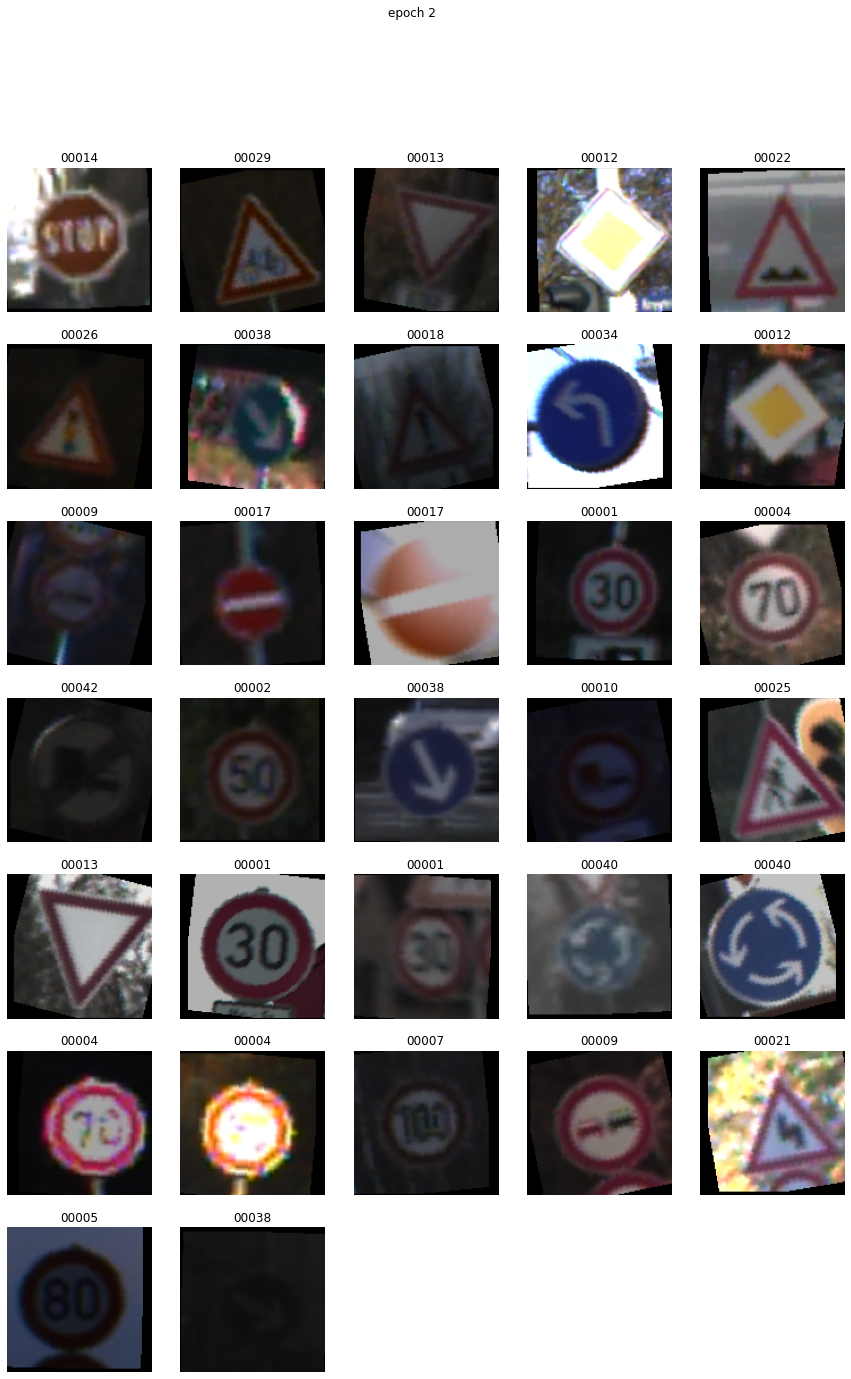

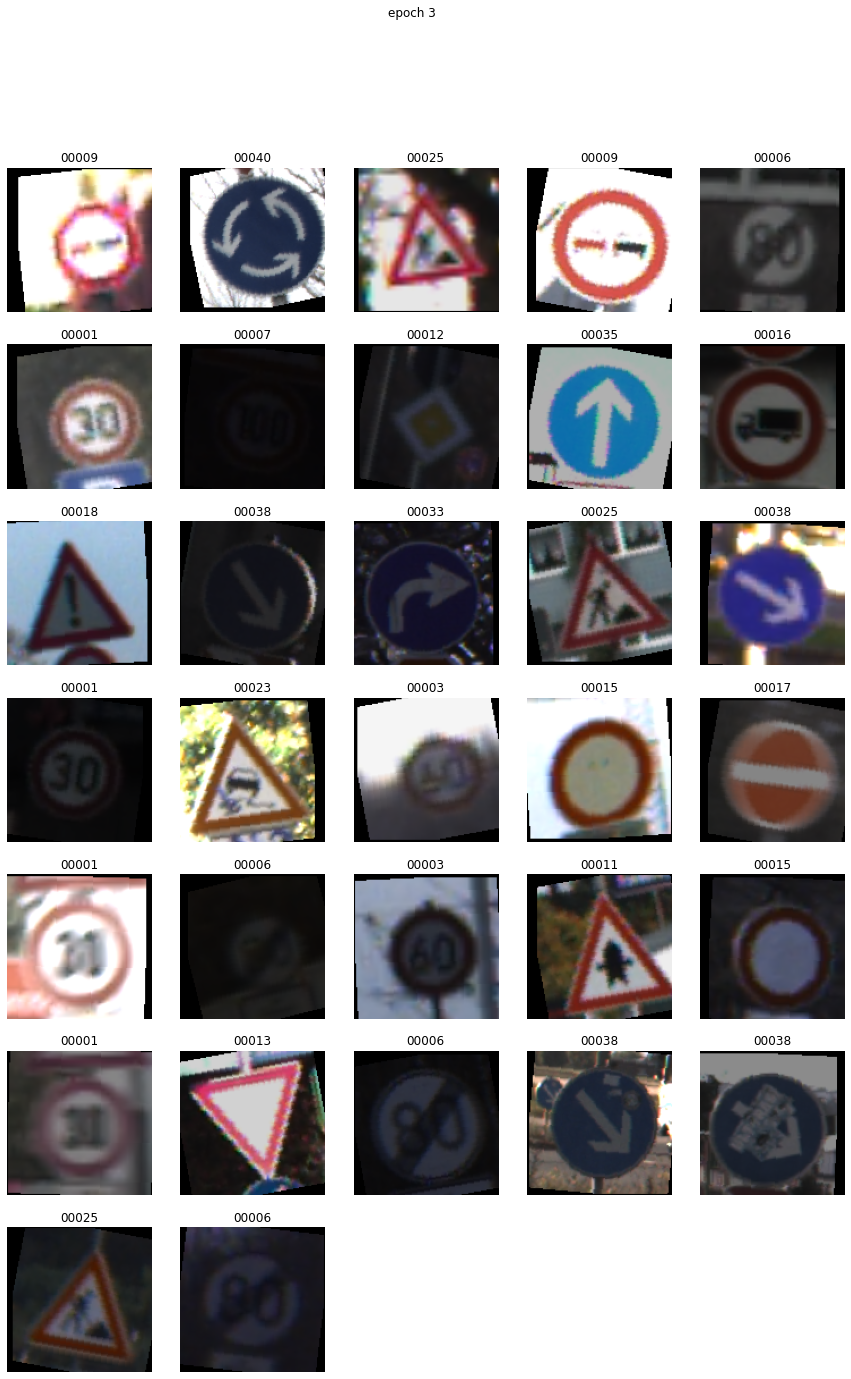

In [12]:

image_batch, label_batch = next(iter(dataset))        
show_batch(image_batch, label_batch.numpy(), 1)

image_batch, label_batch = next(iter(dataset))      
show_batch(image_batch, label_batch.numpy(), 2)

image_batch, label_batch = next(iter(dataset))      
show_batch(image_batch, label_batch.numpy(), 3)


### Define simpler functions for data augmentation

In [18]:
def process_image_trans(image, label):
    
    rx = tf.random.uniform(shape=(), minval=0, maxval=20) - 10
    ry = tf.random.uniform(shape=(), minval=0, maxval=8) - 4
    image = tfa.image.translate(image, [rx, ry])

    return image, label

def process_image_rot(image, label):
    
    r = tf.random.uniform(shape=(), minval=0, maxval=0.5, dtype=tf.dtypes.float32) - 0.25
    image = tfa.image.rotate(image, r)
    image = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 0.4, 1.1, 0.4, 1.1), 0.0, 1.0)

    image = tf.clip_by_value(tf.image.adjust_brightness(image, tf.random.uniform(shape=(), minval=0, maxval=0.1)-0.2),0,1)
    return image, label

## Create a dataset with twice the number of images, one subset is translated, the other is rotated

In [19]:
BATCH_SIZE = 32

datasetA = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
datasetA = datasetA.prefetch(buffer_size=AUTOTUNE)
datasetB = datasetA.map(process_image_trans)
datasetB = datasetB.concatenate(datasetA.map(process_image_rot))
datasetB = datasetB.shuffle(32)
datasetB = datasetB.batch(batch_size = BATCH_SIZE)
datasetB = datasetB.repeat()


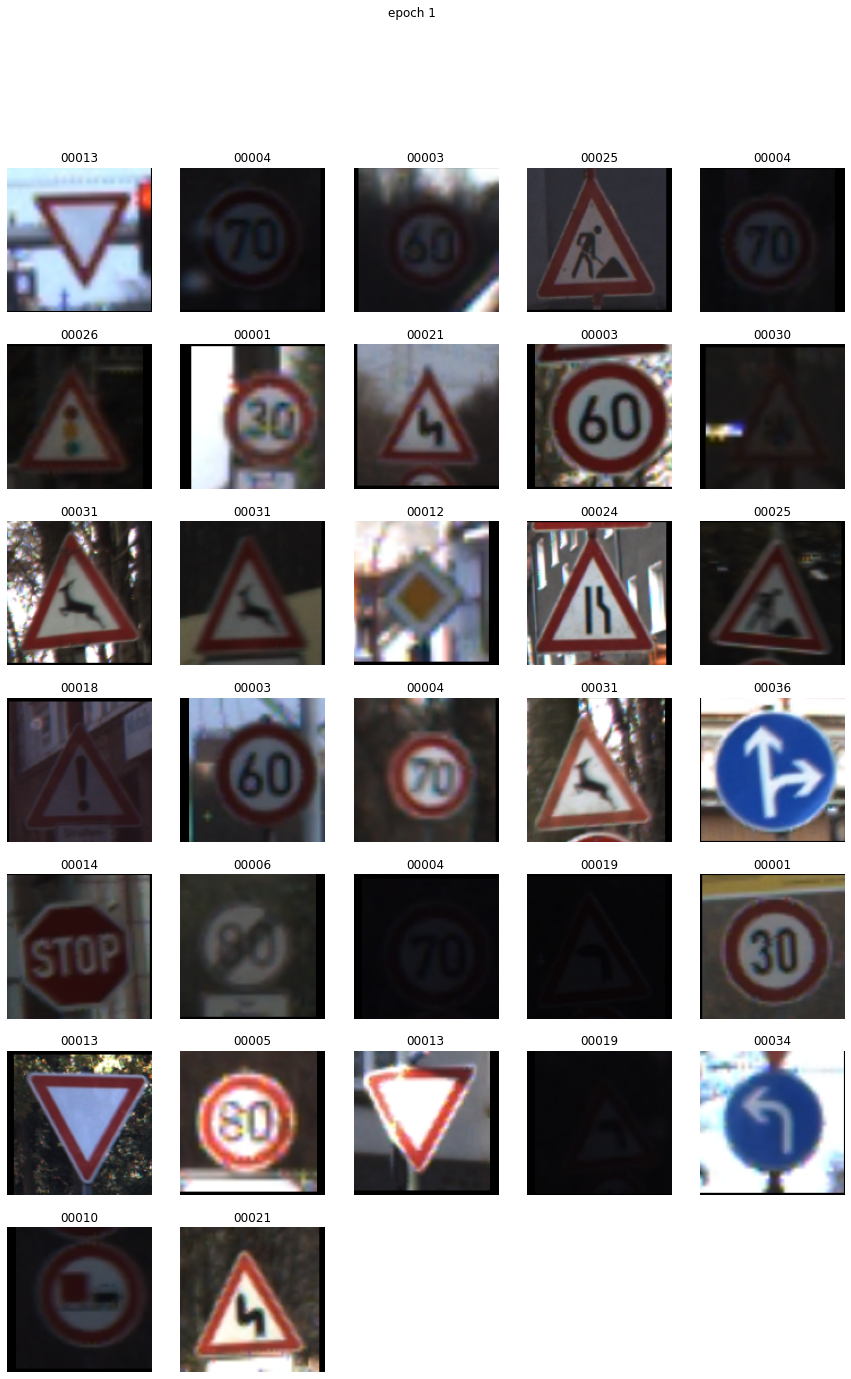

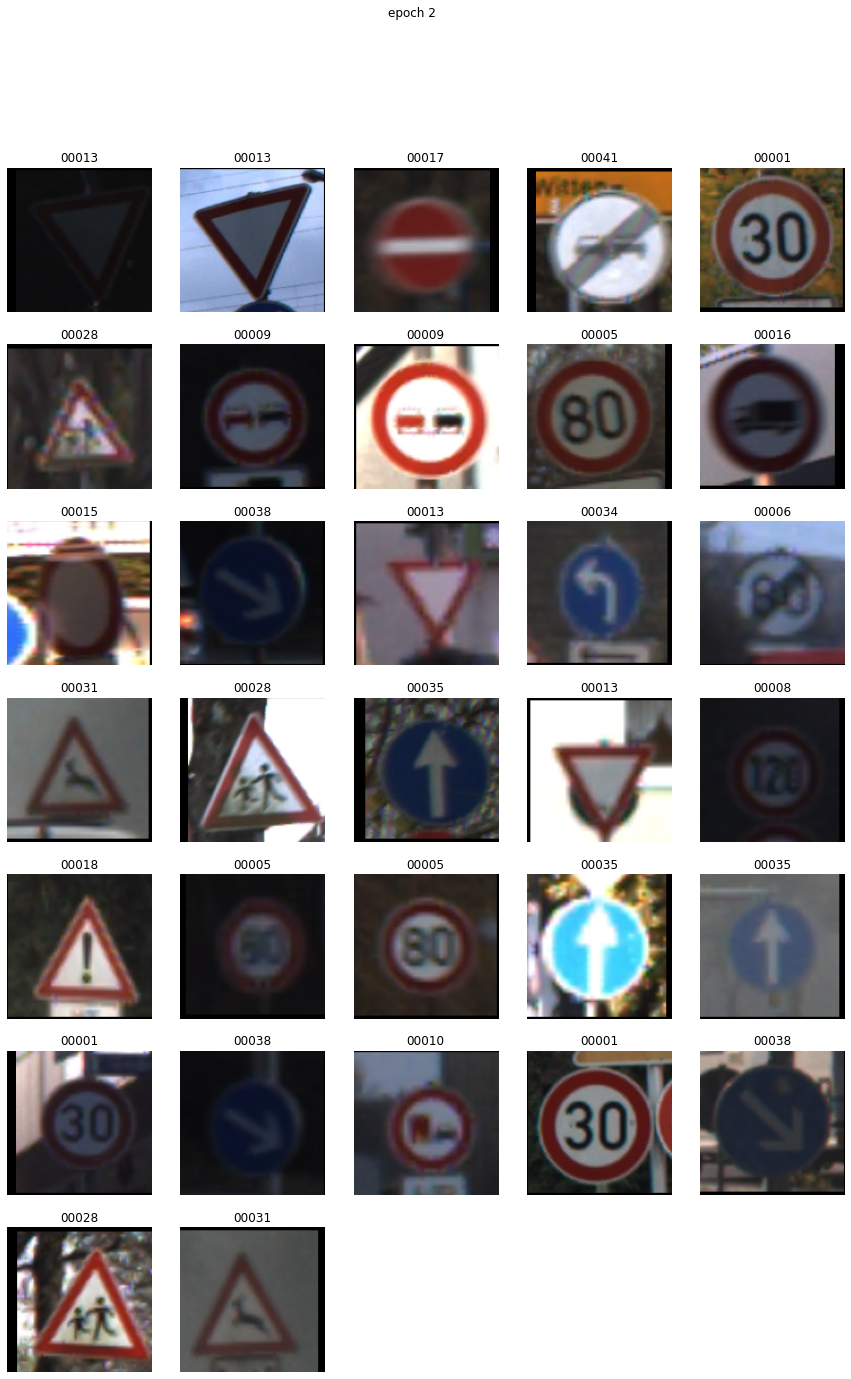

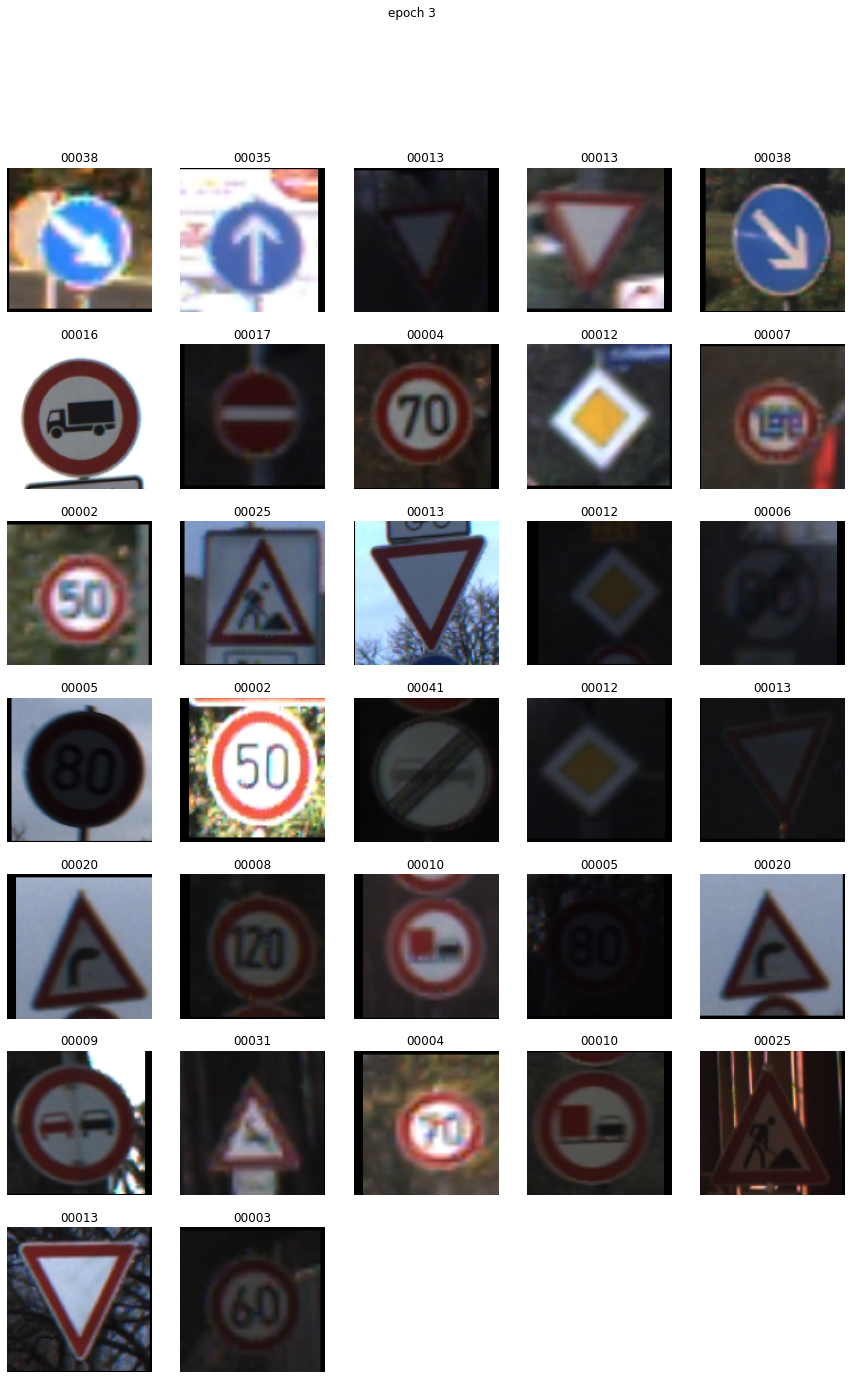

In [20]:
image_batch, label_batch = next(iter(datasetB))        
show_batch(image_batch, label_batch.numpy(), 1)
image_batch, label_batch = next(iter(datasetB))      
show_batch(image_batch, label_batch.numpy(), 2)
image_batch, label_batch = next(iter(datasetB))      
show_batch(image_batch, label_batch.numpy(), 3)
